In [2]:
from pyopenms import*
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
exp = MSExperiment()
MzMLFile().load("C:\\Users\\DELL\\Downloads\\FP062822_10.mzML", exp)

In [24]:
#peptide search
protein_ids = []
peptide_ids = []
SimpleSearchEngineAlgorithm().search("FP062822_10.mzML", "uniprot33.fasta", protein_ids, peptide_ids)

In [25]:
print(len(peptide_ids))

3


In [26]:
df=pd.DataFrame(columns=['peptides','score'])
    

for peptide_id in peptide_ids:
    for hit in peptide_id.getHits():
        df=df.append({'peptides':hit.getSequence(),'score':hit.getScore()},ignore_index=True)
        
print(df)

                         peptides     score
0  HGGTC(Carbamidomethyl)HNEVGSYR  0.338039
1                        NSSFHFLR  0.014190
2                        NSSFHFLR  0.030846


In [27]:
for peptide_id in peptide_ids:
    
      # Peptide identification values
    print (35*"=")
    print ("Peptide ID m/z:", peptide_id.getMZ())
    print ("Peptide ID rt:", peptide_id.getRT())
    print ("Peptide scan index:", peptide_id.getMetaValue("scan_index"))
    print ("Peptide scan name:", peptide_id.getMetaValue("scan_index"))
    print ("Peptide ID score type:", peptide_id.getScoreType())
      # PeptideHits
    for hit in peptide_id.getHits():
        
        print(" - Peptide hit rank:", hit.getRank())
        print(" - Peptide hit charge:", hit.getCharge())
        print(" - Peptide hit sequence:", hit.getSequence())
        mz = hit.getSequence().getMonoWeight(Residue.ResidueType.Full, hit.getCharge()) / hit.getCharge()
        print(" - Peptide hit monoisotopic m/z:", mz)
        print(" - Peptide ppm error:", abs(mz - peptide_id.getMZ())/mz *10**6 )
        print(" - Peptide hit score:", hit.getScore())

Peptide ID m/z: 492.213348388672
Peptide ID rt: 722.48622
Peptide scan index: 649
Peptide scan name: 649
Peptide ID score type: hyperscore
 - Peptide hit rank: 1
 - Peptide hit charge: 3
 - Peptide hit sequence: HGGTC(Carbamidomethyl)HNEVGSYR
 - Peptide hit monoisotopic m/z: 491.8811153125044
 - Peptide ppm error: 675.4336888020617
 - Peptide hit score: 0.3380391001701355
Peptide ID m/z: 504.259583072811
Peptide ID rt: 1090.38378
Peptide scan index: 2547
Peptide scan name: 2547
Peptide ID score type: hyperscore
 - Peptide hit rank: 1
 - Peptide hit charge: 2
 - Peptide hit sequence: NSSFHFLR
 - Peptide hit monoisotopic m/z: 504.25651051947096
 - Peptide ppm error: 6.093234843618378
 - Peptide hit score: 0.014190462417900562
Peptide ID m/z: 504.259709362821
Peptide ID rt: 1096.57086
Peptide scan index: 2556
Peptide scan name: 2556
Peptide ID score type: hyperscore
 - Peptide hit rank: 1
 - Peptide hit charge: 2
 - Peptide hit sequence: NSSFHFLR
 - Peptide hit monoisotopic m/z: 504.25651

In [28]:
seq = "HGGTC(Carbamidomethyl)HNEVGSYR"
tsg = TheoreticalSpectrumGenerator()
theo_spec = MSSpectrum()
p = tsg.getParameters()
p.setValue("add_y_ions", "true")
p.setValue("add_b_ions", "true")
p.setValue("add_metainfo", "true")
tsg.setParameters(p)
peptide = AASequence.fromString(seq)
tsg.getSpectrum(theo_spec, peptide, 1, 2)

In [43]:
exp_spectrum=MSExperiment()
exp_spectrum.addSpectrum(exp[2556])
obs_mz, obs_int = exp[2556].get_peaks()
print(min(obs_mz)) 
print(max(obs_mz)) 
print(exp[2556].get_peaks())

177.824951171875
1186.8929443359375
(array([ 177.82495117,  198.38008118,  219.55996704,  231.21707153,
        276.40286255,  301.30502319,  325.15158081,  330.88357544,
        594.80895996, 1186.89294434]), array([2421.534 , 2275.583 , 2196.5964, 2752.2786, 2273.0193, 2120.005 ,
       2209.076 , 2555.3271, 2705.287 , 3375.9734], dtype=float32))


In [42]:
print(obs_int)

[2421.534  2275.583  2196.5964 2752.2786 2273.0193 2120.005  2209.076
 2555.3271 2705.287  3375.9734]


In [44]:
theo_mz, theo_int = [], []
for mz, intensity in zip(*theo_spec.get_peaks()):
    if mz >= 177.0 and mz <= 1187.0:
        theo_mz.append(mz)
        theo_int.append(intensity)

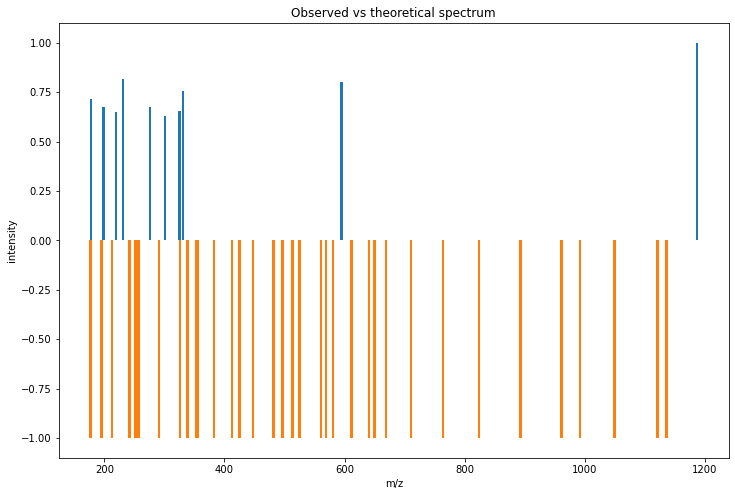

In [45]:
def mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title):
    
    obs_int = [element / max(obs_int) for element in obs_int] # relative intenstiy
    theo_int = [element * -1 for element in theo_int] # invert the intensity for the mirror plot
    plt.figure(figsize=(12,8))
    plt.bar(obs_mz, obs_int, width = 4.0)
    plt.bar(theo_mz, theo_int, width = 4.0)
    plt.title(title)
    plt.ylabel('intensity')
    plt.xlabel('m/z')
    plt.show()
    
title = 'Observed vs theoretical spectrum'
mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title)

In [46]:
alignment = []
spa = SpectrumAlignment()
p = spa.getParameters()
# use 0.5 Da tolerance (Note: for high-resolution data we could also use ppm by setting the is_relative_tolerance value to true)
p.setValue("tolerance", 0.5)
p.setValue("is_relative_tolerance", "false")
spa.setParameters(p)
# align both spectra
observed_spec= exp[649]
spa.getSpectrumAlignment(alignment, theo_spec,exp_spectrum[0])

In [47]:
# Print matching ions and mz from theoretical spectrum
print("Number of matched peaks: " + str(len(alignment)))
print("ion\ttheo. m/z\tobserved m/z")

for theo_idx, obs_idx in alignment:
    ion_name = theo_spec.getStringDataArrays()[0][theo_idx].decode()
    ion_charge = theo_spec.getIntegerDataArrays()[0][theo_idx]
    print(ion_name + "\t" + str(ion_charge) + "\t"
      + str(theo_spec[theo_idx].getMZ())
      + "\t" + str(exp_spectrum[0][obs_idx].getMZ()))

Number of matched peaks: 1
ion	theo. m/z	observed m/z
b6++	2	325.626816890021	325.1515808105469


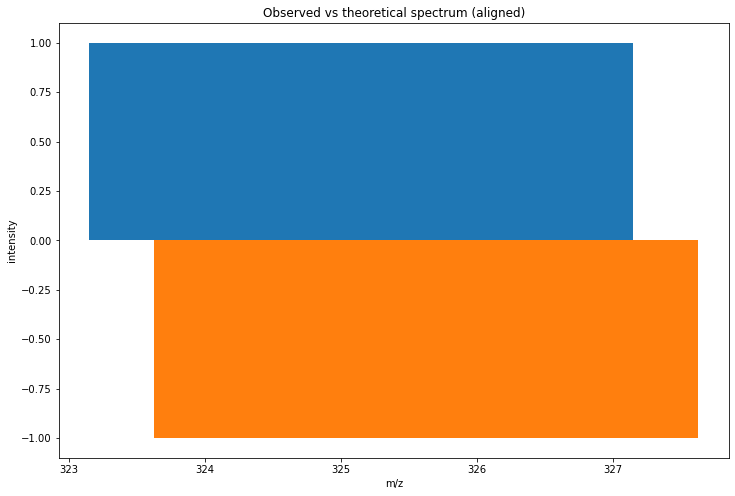

In [48]:
theo_mz, theo_int, obs_mz, obs_int = [], [], [], []
for theo_idx, obs_idx in alignment:
    theo_mz.append(theo_spec[theo_idx].getMZ())
    theo_int.append(theo_spec[theo_idx].getIntensity())
    obs_mz.append(exp_spectrum[0][obs_idx].getMZ())
    obs_int.append(exp_spectrum[0][obs_idx].getIntensity())

title = 'Observed vs theoretical spectrum (aligned)'
mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title)